In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
%matplotlib inline

# Основне завдання

## Для даних по титаніку titanic.csv побудувати модель, в якій можна визначити, чи виживе пасажир, заповнивши решту параметрів. Використати декілька методів. Порівняти результати.


### 1. Зчитування датасету у датафрейм та виведення перших та останніх п'яти записів

In [2]:
titanic_df = pd.read_csv('../data/titanic.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


### 2. Форматування назв стовпців та виведення стовпців, що містять пропущені значення

In [4]:
titanic_df.columns = titanic_df.columns.str.lower()
titanic_df = titanic_df.rename(columns={'passengerid': 'passenger_id', 'pclass': 'class'})
titanic_df.describe()

,passenger_id,survived,class,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
titanic_df.loc[:, titanic_df.isna().sum() > 0].isna().sum()

age         177
cabin       687
embarked      2
dtype: int64

### Можна побачити, що стовпець з номерами кают (cabin) містить дуже багато пропущених значень відносно розміру длатафрейму, тому його треба видалити. Стовпець age скоріш за все корелює з виживанням, тому його не варто видаляти. Стовпець embarked, що містить назви портів, містить лише 2 пропущених значення.

### 3. Описові статистики кількісних та порядкових ознак (стовпців)

In [6]:
titanic_df.describe()

,passenger_id,survived,class,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 4. Опис номінальних ознак (стовпців)

In [7]:
titanic_df.describe(include=['O'])

,name,sex,ticket,cabin,embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


### Оскільки якісна (номінальна) ознака (стовпець) ticket містить аж 681 унікальне значення, та до того ж очевидно, що номер квитка навряд корелює з виживанням, то можна видалити цей стовпець.

### 5. Видалення стовпців ticket, cabin (з наведених вище причин) та passenger_id й name, бо дані стовпці ніяк не корелює з виживанням

In [8]:
titanic_df.drop(columns=['ticket', 'cabin', 'passenger_id', 'name'], inplace=True)
titanic_df.head()

,survived,class,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### 6. Створення функції, яка використовує критерій узгодженості Пірсона для виявлення наявності статистично суттєвого зв'язку між заданою якісною ознакою (стовпцем) та цільовою змінною (виживанням).

In [9]:
def get_correlation_categorical(column: str, alpha=0.05, target_column: str = 'survived'):
    contingency_table = pd.crosstab(titanic_df[column], titanic_df[target_column])
    stat, p, dof, expected = chi2_contingency(contingency_table)
    return p, p <= alpha

### 7. Використання цієї функції для якісних змінних (стовпців) датафрейму

In [10]:
categorical_columns = [c for c in titanic_df.columns if c not in ['survived', 'age', 'fare']]
p_list, is_correlated_list = [], []
for c in categorical_columns:
    p, is_correlated = get_correlation_categorical(c)
    p_list.append(p)
    is_correlated_list.append(is_correlated)

pd.DataFrame({'p_value': p_list, 'is_correlated': is_correlated_list}, index=categorical_columns)

,p_value,is_correlated
class,4.549252e-23,True
sex,1.197357e-58,True
sibsp,1.558581e-06,True
parch,9.703526e-05,True
embarked,1.769922e-06,True


### Отримані результати вказують, що всі якісні змінні мають статистично суттєвий зв'язок з цільовою (приймаємо альтернативну гіпотезу для кожної змінної).

### 8. Зіставлення якісних ознак з цільовою змінною (для кожного унікального значення якісної зіставляється середнє значення цільової змінної)

In [11]:
def pivot_features(column: str, target_column: str = 'survived'):
    return titanic_df[[column, target_column]].groupby([column]).mean().sort_values(by=target_column, ascending=False)

In [12]:
pivot_features('class')

,survived
class,
1,0.629630
2,0.472826
3,0.242363


In [13]:
pivot_features('sex')

,survived
sex,
female,0.742038
male,0.188908


In [14]:
pivot_features('embarked')

,survived
embarked,
C,0.553571
Q,0.389610
S,0.336957


### Отже, можна побачити досить сильний зв'язок між класом пасажирів та їх виживанням, статтю та виживанням. Також видно не такий сильний зв'язок між портом посадки та виживанням.

In [15]:
pivot_features('sibsp')

,survived
sibsp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [16]:
pivot_features('parch')

,survived
parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000


### Зв'язок між кількістю браттів та сестер/чоловіків (дружин) на борту й виживанням та зв'язок між кількістю батьків/дітей на борту й виживанням є не такими явними, тому доцільно буде об'єднати ці дві змінні в одну (family_size).

In [17]:
titanic_df['family_size'] = titanic_df['sibsp'] + titanic_df['parch']
pivot_features('family_size')

,survived
family_size,
3,0.724138
2,0.578431
1,0.552795
6,0.333333
0,0.303538
4,0.200000
5,0.136364
7,0.000000
10,0.000000


### Отримана номінальна змінна має аж 9 можливих значень, тому краще створити бінарну номінальну змінну (стовпець) is_alone, яка вказує, чи подорожував пасажир один, а стовпці sibsp, parch та family_size відповідно видалити.

In [18]:
titanic_df['is_alone'] = 0
titanic_df.loc[titanic_df['family_size'] == 0, 'is_alone'] = 1
pivot_features('is_alone')

,survived
is_alone,
0,0.505650
1,0.303538


In [19]:
titanic_df = titanic_df.drop(columns=['family_size', 'sibsp', 'parch'])
titanic_df.head()

,survived,class,sex,age,fare,embarked,is_alone
0,0,3,male,22.0,7.2500,S,0
1,1,1,female,38.0,71.2833,C,0
2,1,3,female,26.0,7.9250,S,1
3,1,1,female,35.0,53.1000,S,0
4,0,3,male,35.0,8.0500,S,1


### 9. Побудова гістограми розподілу віку пасажирів, що вижили та не вижили

/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


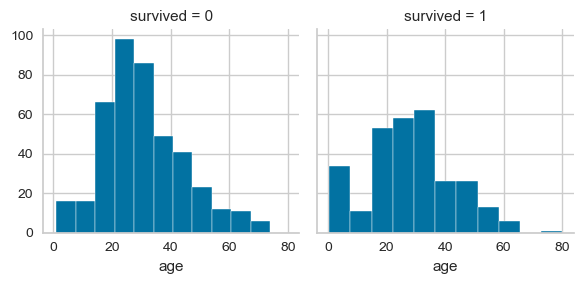

In [20]:
sns.FacetGrid(titanic_df, col='survived').map(plt.hist, 'age', bins=11);

### 10. Перетворення стовпця fare (вартість квитка) з відносної шкали в інтервальну та врешті-решт у порядкову

In [21]:
titanic_df['fare_band'] = pd.cut(titanic_df['fare'], 4)
pivot_features('fare_band')

,survived
fare_band,
"(384.247, 512.329]",1.000000
"(128.082, 256.165]",0.724138
"(256.165, 384.247]",0.666667
"(-0.512, 128.082]",0.368113


In [22]:
bands = titanic_df['fare_band'].unique().sort_values()
for i in range(1, titanic_df['fare_band'].nunique() + 1):
    titanic_df.loc[titanic_df['fare_band'] == bands[i - 1], 'fare'] = i
    titanic_df['fare'] = titanic_df['fare'].astype('int')

titanic_df = titanic_df.drop(columns='fare_band')
titanic_df.head()

,survived,class,sex,age,fare,embarked,is_alone
0,0,3,male,22.0,1,S,0
1,1,1,female,38.0,1,C,0
2,1,3,female,26.0,1,S,1
3,1,1,female,35.0,1,S,0
4,0,3,male,35.0,1,S,1


### 11. Заповнення пропущених значень стовпця age (вік) середнім значенням та стовпця embarked (порт посадки) модою

In [23]:
titanic_df['age'] = titanic_df['age'].fillna(value=titanic_df['age'].mean())
most_frequent_port = titanic_df['embarked'].dropna().mode()[0]
titanic_df['embarked'] = titanic_df['embarked'].fillna(most_frequent_port)
titanic_df.isna().sum()

survived    0
class       0
sex         0
age         0
fare        0
embarked    0
is_alone    0
dtype: int64

### 12. Використання one-hot-encoding для номінальних ознак sex та embarked та видалення

In [24]:
titanic_df['embarked'] = titanic_df['embarked'].str.lower()
titanic_df = pd.get_dummies(titanic_df, columns=['sex', 'embarked'], drop_first=True)
titanic_df.head()

,survived,class,age,fare,is_alone,sex_male,embarked_q,embarked_s
0,0,3,22.0,1,0,True,False,True
1,1,1,38.0,1,0,False,False,False
2,1,3,26.0,1,1,False,False,True
3,1,1,35.0,1,0,False,False,True
4,0,3,35.0,1,1,True,False,True


### 13. Розділення датасету на навчальні та тестові набори у відношенні 75% до 25%

In [25]:
X, y = titanic_df.iloc[:, 1:].values, titanic_df['survived'].values

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

### 14. Побудова моделі логістичної з використанням стандартизації змінних перед прогнозуванням та підбором оптимальних гіперпараметрів серед заданих з використанням крос-валідації

In [27]:
logistic_regression_pipe = Pipeline([('sc', StandardScaler()), ('lr', LogisticRegression())])
param_grid = {'lr__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100]}
logistic_regression_gs = GridSearchCV(logistic_regression_pipe, param_grid=param_grid, scoring='accuracy', n_jobs=-1)
logistic_regression_gs.fit(X, y)
print(f'Best accuracy: {logistic_regression_gs.best_score_:.2%}, best params: {logistic_regression_gs.best_params_}')

Best accuracy: 79.01%, best params: {'lr__C': 0.05}


In [28]:
print(f'Test accuracy: {logistic_regression_gs.score(X_test, y_test):.2%}')

Test accuracy: 78.03%


### 15. Побудова моделі KNN (k найближчих сусідів) з використанням стандартизації змінних перед прогнозуванням та підбором оптимальних гіперпараметрів серед заданих з використанням крос-валідації

In [29]:
knn_pipe = Pipeline([('sc', StandardScaler()),
                     ('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors': range(1, 50), 'knn__p': range(1, 4)}
knn_gs = GridSearchCV(knn_pipe, param_grid=param_grid, scoring='accuracy', n_jobs=-1)
knn_gs.fit(X_train, y_train)
print(f'Best accuracy: {knn_gs.best_score_:.2%}, best params: {knn_gs.best_params_},')

Best accuracy: 81.30%, best params: {'knn__n_neighbors': 14, 'knn__p': 1},


In [30]:
print(f'Test accuracy: {knn_gs.score(X_test, y_test):.2%}')

Test accuracy: 81.17%


### 16. Побудова моделі SVC (метод опорних векторів) з використанням стандартизації змінних перед прогнозуванням та підбором оптимальних гіперпараметрів серед заданих з використанням крос-валідації

In [31]:
svm_pipe = Pipeline([('sc', StandardScaler()), ('svm', SVC(gamma='auto'))])
param_grid = {'svm__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100], 'svm__kernel': ['rbf', 'linear']}
svm_gs = GridSearchCV(svm_pipe, param_grid=param_grid, scoring='accuracy', n_jobs=-1)
svm_gs.fit(X_train, y_train)
print(f'Best accuracy: {svm_gs.best_score_:.2%}, best params: {svm_gs.best_params_}')

Best accuracy: 80.54%, best params: {'svm__C': 0.5, 'svm__kernel': 'rbf'}


In [32]:
print(f'Test accuracy: {svm_gs.score(X_test, y_test):.2%}')

Test accuracy: 81.61%


### 17. Використання метрик accuracy на тестових наборах для оцінки моделей та їх порівняння

In [33]:
def get_score_list(classifiers, X_data, y_data):
    return [c.score(X_data, y_data) for c in classifiers]


classifiers_list = [knn_gs, svm_gs, logistic_regression_gs]
pd.DataFrame({'accuracy_train': get_score_list(classifiers_list, X_train, y_train),
              'accuracy_test': get_score_list(classifiers_list, X_test, y_test)},
             index=['knn', 'svm', 'logistic_regression']).sort_values(by='accuracy_test', ascending=False)

,accuracy_train,accuracy_test
svm,0.839820,0.816143
knn,0.818862,0.811659
logistic_regression,0.797904,0.780269


### Отже, можна побачити, що в залежності від розбиття на навчальні та тестові набори, результати дещо відрізняються, проте в середньому svm та knn демонструють кращі результати. Така нестабільність результатів є наслідком малого розміру вибірки. Альтернативним варіантом оцінювання моделей є крос-валідація.

# Додаткове завдання

## 1. Визначити, який регіон домінує в кластерах по ВВП на душу населення та щільності населення

### 1.1 Зчитування датасету з csv-файлу в датафрейм та виведення його перших та останніх п'яти рядків

In [34]:
df = pd.read_csv('../data/Data2.csv', sep=';', encoding="ISO-8859-1")
df.head()

,Country Name,Region,GDP per capita,Populatiion,CO2 emission,Area
0,Afghanistan,South Asia,"561,7787463",34656032.0,"9809,225",652860
1,Albania,Europe & Central Asia,"4124,98239",2876101.0,"5716,853",28750
2,Algeria,Middle East & North Africa,"3916,881571",40606052.0,"145400,217",2381740
3,American Samoa,East Asia & Pacific,"11834,74523",55599.0,NaN,200
4,Andorra,Europe & Central Asia,"36988,62203",77281.0,"462,042",470


In [35]:
df.tail()

,Country Name,Region,GDP per capita,Populatiion,CO2 emission,Area
212,Virgin Islands (U.S.),Latin America & Caribbean,NaN,102951.0,NaN,350
213,West Bank and Gaza,Middle East & North Africa,"2943,404534",4551566.0,NaN,6020
214,"Yemen, Rep.",Middle East & North Africa,"990,334774",27584213.0,"22698,73",527970
215,Zambia,Sub-Saharan Africa,"1269,573537",16591390.0,"4503,076",752610
216,Zimbabwe,Sub-Saharan Africa,"1029,076649",16150362.0,"12020,426",390760


### У даному датасеті присутні пропущені значення (NaN), дублікати відсутні, наявні від’ємні значення, типи даних стовпців з числовими значеннями не є числовими, замість крапки використана кома для розділення дробової частини числа, назви країн мають зайві частини.Таким чином, треба виконати виправлення помилок у даних та відформатовано їх (аналогічно до 3 лабораторної роботи).

In [36]:
df = df.rename(columns={'Populatiion': 'Population'})
for column in ['GDP per capita', 'CO2 emission', 'Area']:
    df[column] = df[column].str.replace(',', '.')
    df[column] = df[column].str.replace('-', '')
    df[column] = df[column].astype(float)
country_mapping = {'Congo, Dem. Rep.': 'Democratic Republic of the Congo', 'Congo, Rep.': 'Republic of the Congo'}
df['Country Name'] = df['Country Name'].replace(country_mapping)
df['Country Name'] = df['Country Name'].str.extract(r'([a-zA-Z\s\.]+)')
df.fillna(df.mean(numeric_only=True), inplace=True)
df['Population'] = df['Population'].astype('int')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,country_name,region,gdp_per_capita,population,co2_emission,area
0,Afghanistan,South Asia,561.778746,34656032,9809.225000,652860.0
1,Albania,Europe & Central Asia,4124.982390,2876101,5716.853000,28750.0
2,Algeria,Middle East & North Africa,3916.881571,40606052,145400.217000,2381740.0
3,American Samoa,East Asia & Pacific,11834.745230,55599,165114.116337,200.0
4,Andorra,Europe & Central Asia,36988.622030,77281,462.042000,470.0


### 1.2 Створення стовпця щільності населення

In [37]:
df['population_density'] = df['population'] / df['area']
df.head()

,country_name,region,gdp_per_capita,population,co2_emission,area,population_density
0,Afghanistan,South Asia,561.778746,34656032,9809.225000,652860.0,53.083405
1,Albania,Europe & Central Asia,4124.982390,2876101,5716.853000,28750.0,100.038296
2,Algeria,Middle East & North Africa,3916.881571,40606052,145400.217000,2381740.0,17.048902
3,American Samoa,East Asia & Pacific,11834.745230,55599,165114.116337,200.0,277.995000
4,Andorra,Europe & Central Asia,36988.622030,77281,462.042000,470.0,164.427660


### 1.3 Використання алгортму K середніх для кластерного аналізу та оцінка найкращого k за допомогою візуалізації "ліктя" (Elbow curve)

/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set th

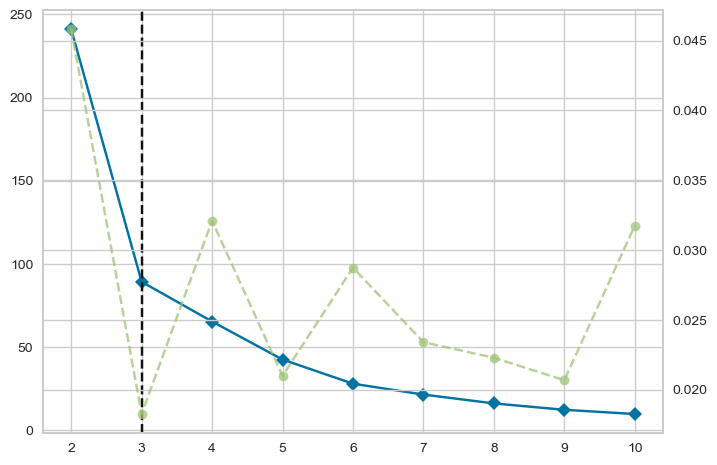

In [38]:
sc = StandardScaler()
data_std = sc.fit_transform(df[['gdp_per_capita', 'population_density']])
state = 42
kmeans = KMeans(random_state=state)
visualizer = KElbowVisualizer(kmeans, k=(2, 11))
visualizer.fit(data_std);

### Можна побачити, що при k = 3 маємо так званий "лікоть", тобто, при збільшенні k зменшення суми квадратів відстаней у межах кластерів вже не є таким суттєвим. Проте це ще не означає, що дане значення є оптимальним.

### 1.4 Використання методу силуету для обрання оптимальної кількості кластерів

/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k = 2 the average silhouette score is: 0.8962448687095929
For k = 3 the average silhouette score is: 0.7472495035770288


/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k = 4 the average silhouette score is: 0.5971925938298993
For k = 5 the average silhouette score is: 0.6133981961821795
For k = 6 the average silhouette score is: 0.6138475336855724


/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k = 7 the average silhouette score is: 0.6111172413140653
For k = 8 the average silhouette score is: 0.6070128147987656


/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k = 9 the average silhouette score is: 0.6049765535854422
For k = 10 the average silhouette score is: 0.6125080614441599


/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


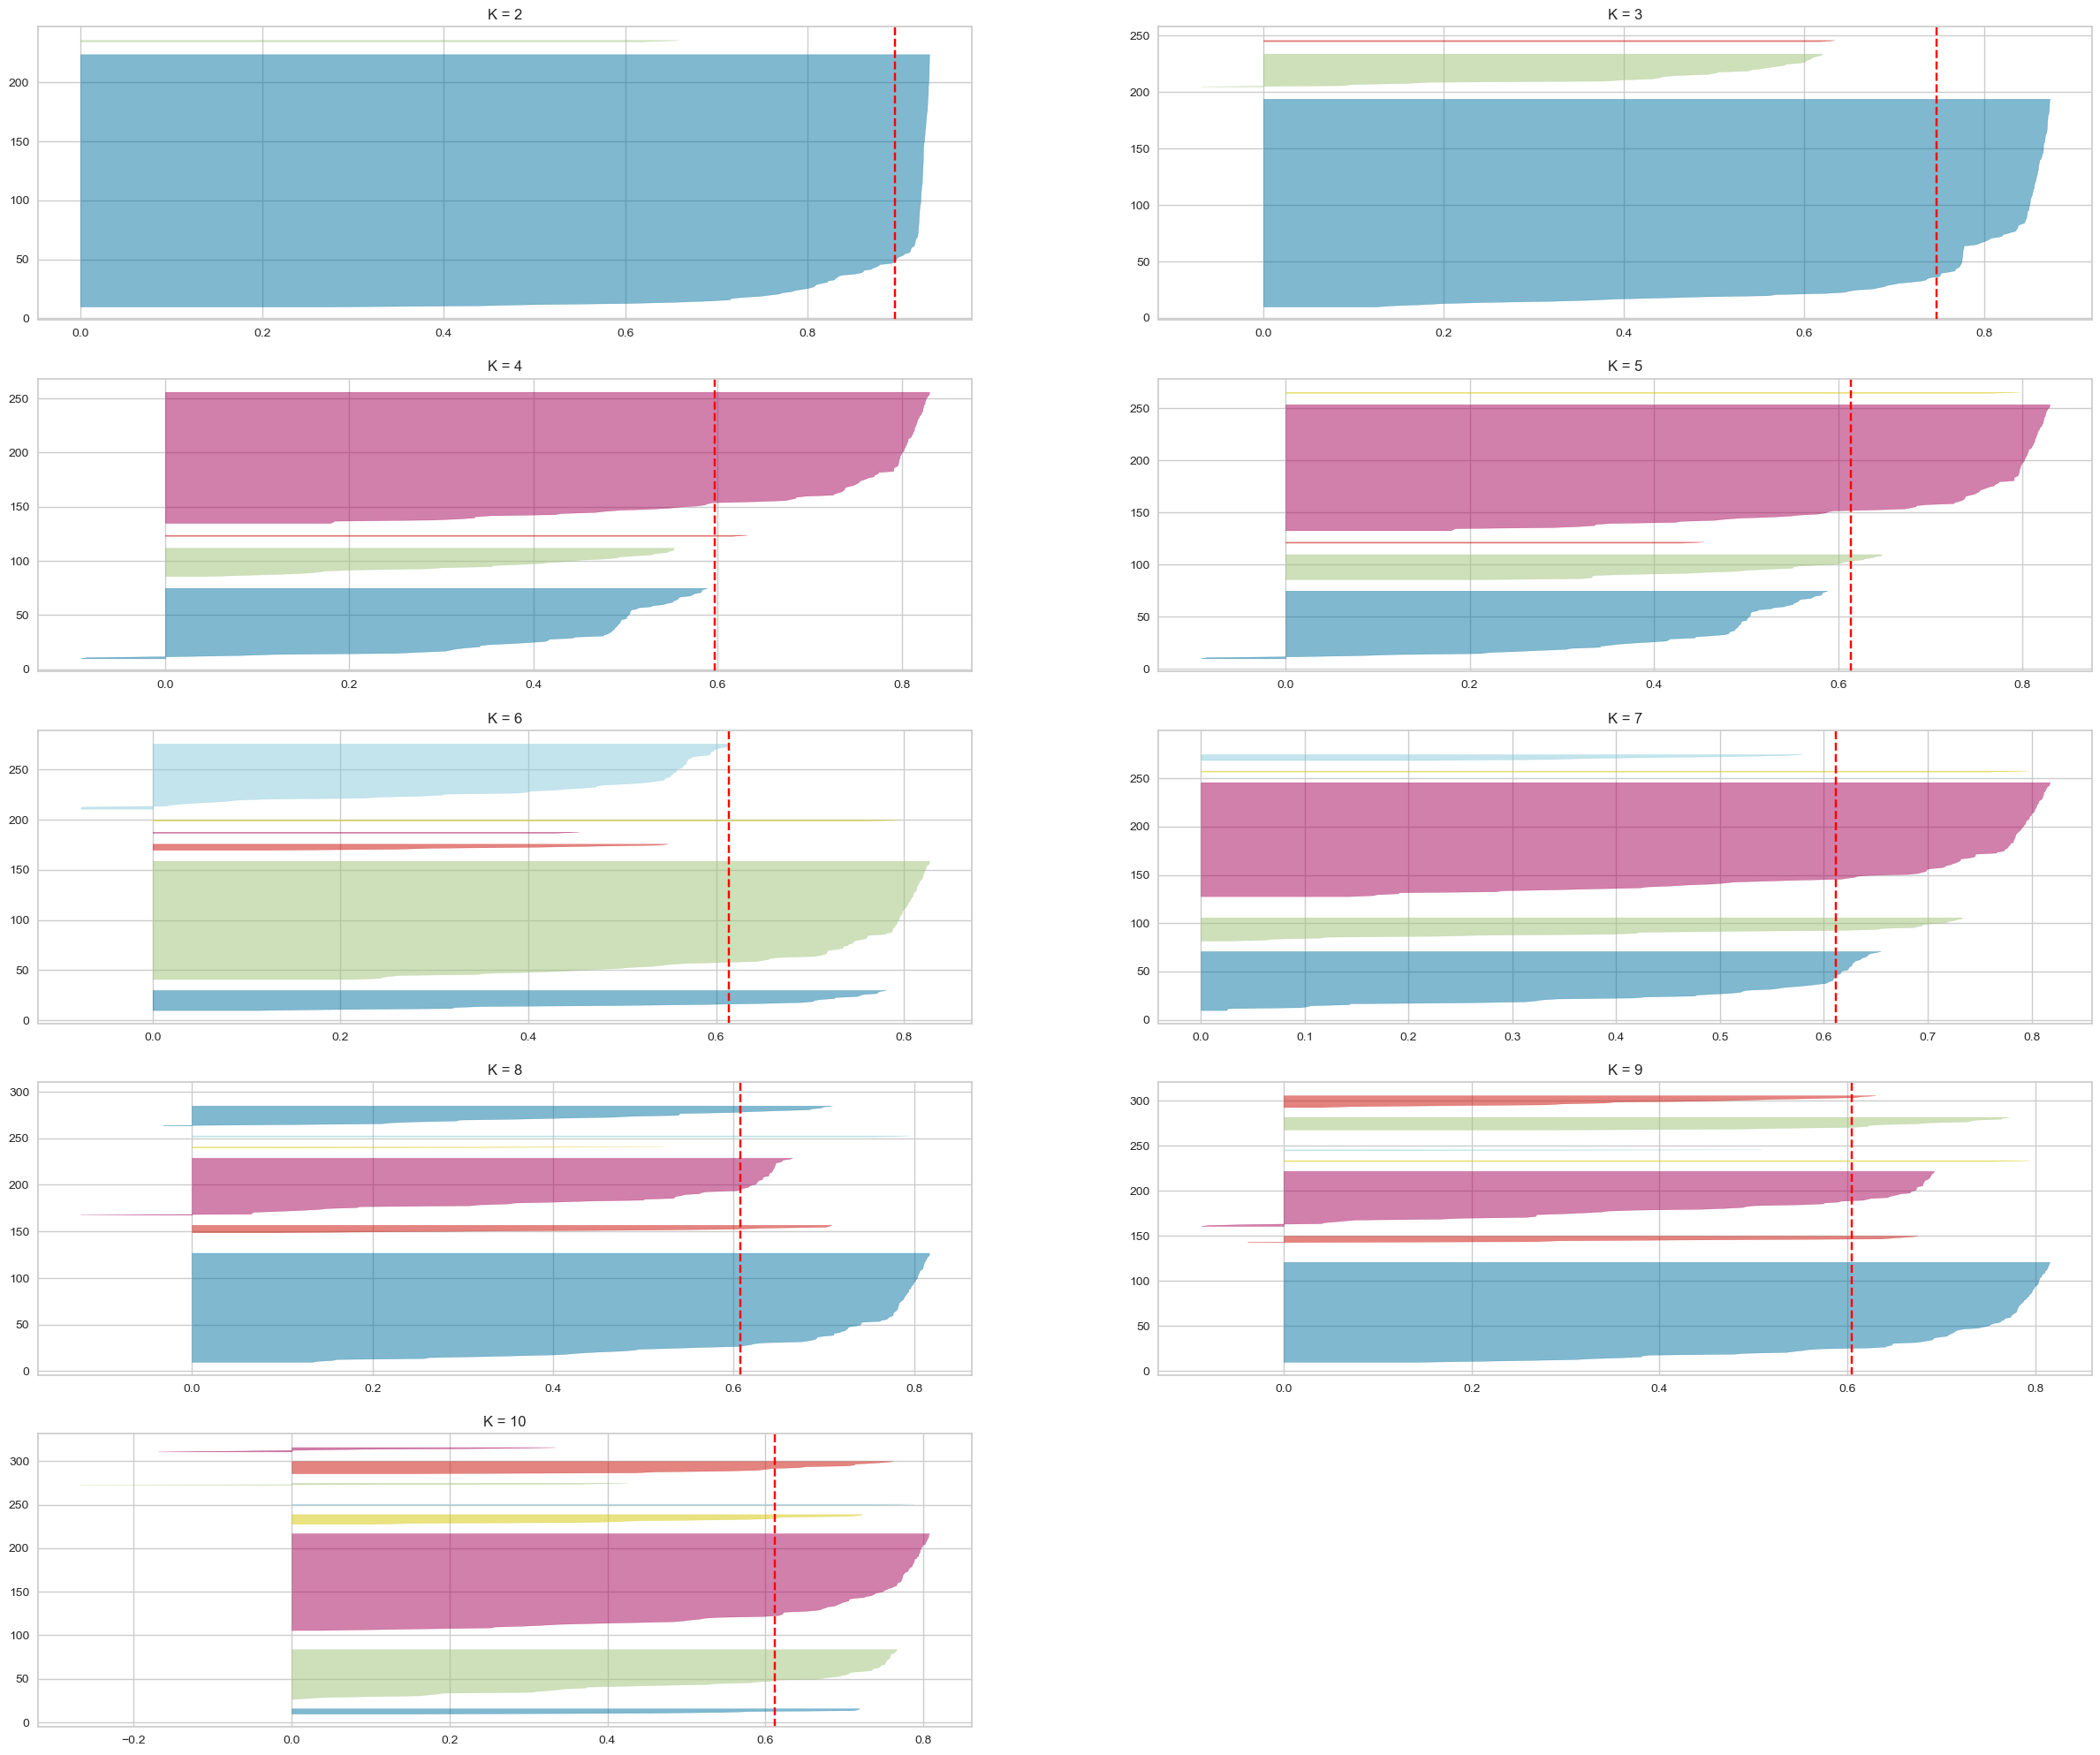

In [39]:
fig, ax = plt.subplots(5, 2, figsize=(30, 25))
ax[4][1].set_visible(False)
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=state)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q - 1][mod])
    ax[q - 1][mod].set_title(f'K = {i}')
    visualizer.fit(data_std)
    print(f'For k = {i} the average silhouette score is: {visualizer.silhouette_score_}')

### Найбільша середня величина силуету досягається при k = 2, проте оптимальна кількість кластерів буде такою, при якій всі (або майже всі) кластери мають вище значення величини силуету за середнє (червона лінія), та при цьому розміри кластерів несильно відрізняються. Таким чином, можна побачити, що оптимальним є k = 9.

### 1.5 Візуалізація отриманих кластерів

/Users/kyryl/miniforge3/envs/LabsDataAnalysis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


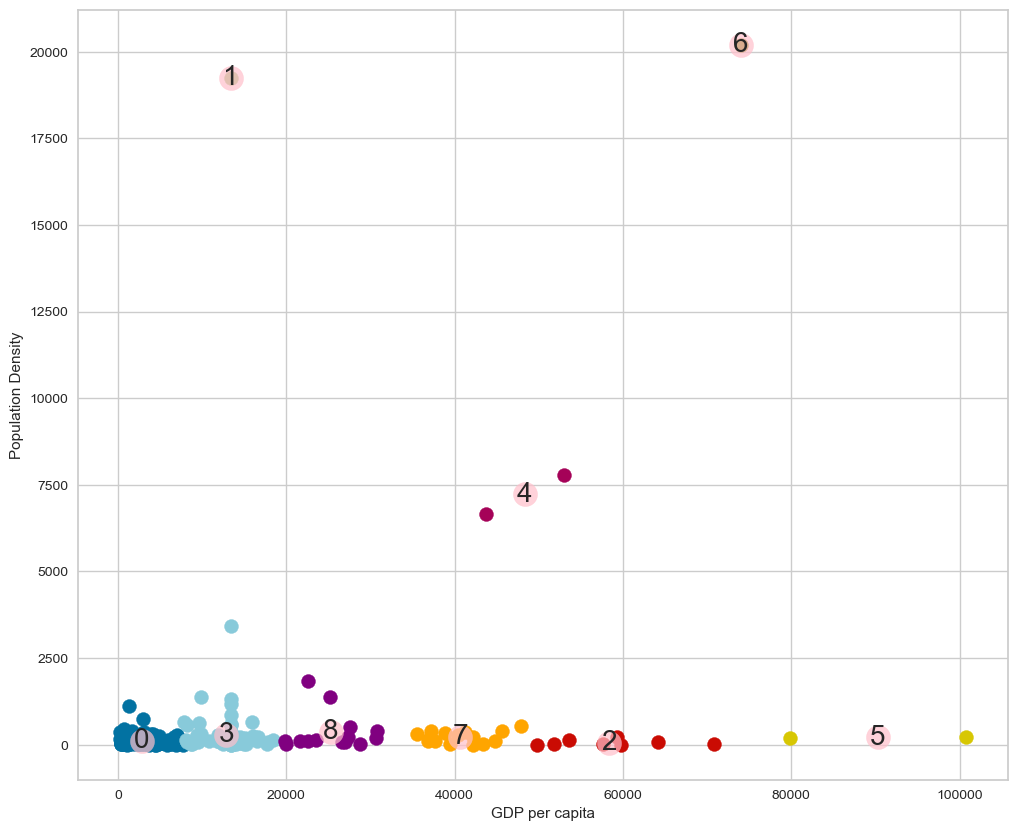

In [40]:
k = 9
kmeans = KMeans(n_clusters=k, random_state=state)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'olive', 'orange', 'purple']
kmeans.fit(data_std)
clustered_df = df.copy()
clustered_df['cluster_label'] = kmeans.labels_
centers = kmeans.cluster_centers_
centers = sc.inverse_transform(centers)
plt.figure(figsize=(12, 10))
for i in range(k):
    plt.scatter(clustered_df['gdp_per_capita'][clustered_df['cluster_label'] == i],
                clustered_df['population_density'][clustered_df['cluster_label'] == i], color=colors[i], s=100)
    plt.scatter(centers[i, 0], centers[i, 1], c='pink', s=300, alpha=0.7)
    plt.annotate(i, (centers[i, 0], centers[i, 1]), fontsize=20, ha='center', va='center')
plt.xlabel('GDP per capita')
plt.ylabel('Population Density');

### 1.6 Групування по кластерам та регіонам та визначення регіонів, що домінують у кожному кластері

In [41]:
regions_clusters_df = clustered_df.groupby(['cluster_label', 'region']).count()['country_name']
regions_clusters_df

cluster_label  region                    
0              East Asia & Pacific           19
               Europe & Central Asia         18
               Latin America & Caribbean     17
               Middle East & North Africa     9
               South Asia                     7
               Sub-Saharan Africa            42
1              Europe & Central Asia          1
2              East Asia & Pacific            1
               Europe & Central Asia          5
               Middle East & North Africa     1
               North America                  1
3              East Asia & Pacific            8
               Europe & Central Asia         18
               Latin America & Caribbean     23
               Middle East & North Africa     5
               North America                  1
               South Asia                     1
               Sub-Saharan Africa             6
4              East Asia & Pacific            2
5              Europe & Central Asia          

In [42]:
max_counts, dominant_regions = [], []
for i in range(k):
    max_counts.append(regions_clusters_df[i].max())
    dominant_regions.append(regions_clusters_df[i].idxmax())

pd.DataFrame({'cluster_label': range(k), 'dominant_region': dominant_regions, 'countries': max_counts}).set_index(
    'cluster_label')

,dominant_region,countries
cluster_label,,
0,Sub-Saharan Africa,42
1,Europe & Central Asia,1
2,Europe & Central Asia,5
3,Latin America & Caribbean,23
4,East Asia & Pacific,2
5,Europe & Central Asia,2
6,East Asia & Pacific,1
7,Europe & Central Asia,9
8,Europe & Central Asia,5


## 2. Вивести частотні гістограми всіх показників файла Data2.csv, використовуючи цикл

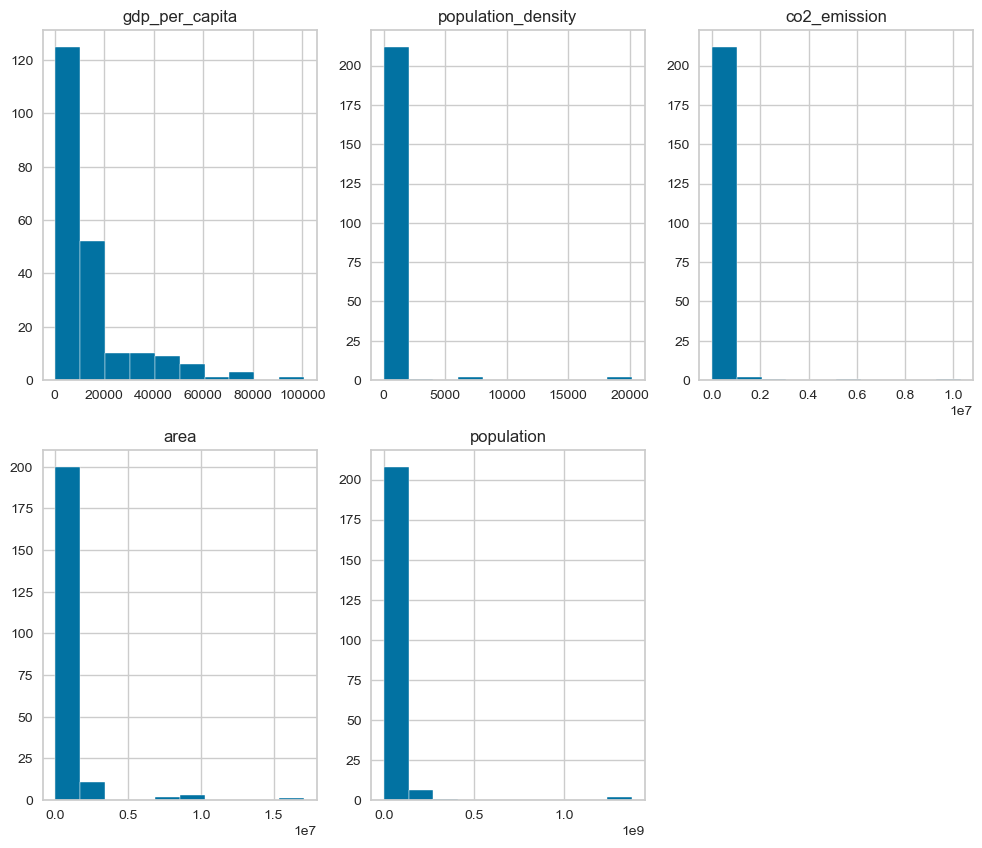

In [43]:
fig, ax = plt.subplots(2, 3, figsize=(12, 10))
ax[1][2].set_visible(False)
bin_count = int(np.ceil(np.log2(df.shape[0])) + 1)
df: pd.DataFrame
for i, column in enumerate(df.select_dtypes(include=np.number).columns):
    df[column].hist(ax=ax[i % 2, i % 3])
    ax[i % 2, i % 3].set_title(column)

## 3. Створити функцію, яка на вхід отримує два набори даних, перевіряє чи є лінійна залежність та виводить True чи False (будемо розуміти під «є лінійна залежність», якщо коефіцієнт кореляції по модулю більше 0,8)


### 3.1 Створення функції для визначення наявності лінійної залежності між двома наборами даних

In [44]:
def is_linearly_related(series_1: pd.Series, series_2: pd.Series):
    return math.fabs(series_1.corr(series_2)) > 0.8

### 3.2 Використання даної функції для даного датафрейму

In [45]:
numeric_columns = df.select_dtypes(include=np.number).columns
columns_1_list, columns_2_list, correlations = [], [], []
for i, column_1 in enumerate(numeric_columns):
    for column_2 in numeric_columns[i + 1:]:
        columns_1_list.append(column_1)
        columns_2_list.append(column_2)
        correlations.append(is_linearly_related(df[column_1], df[column_2]))

pd.DataFrame({'column_1': columns_1_list, 'column_2': columns_2_list, 'is_correlated': correlations})

,column_1,column_2,is_correlated
0,gdp_per_capita,population,False
1,gdp_per_capita,co2_emission,False
2,gdp_per_capita,area,False
3,gdp_per_capita,population_density,False
4,population,co2_emission,True
5,population,area,False
6,population,population_density,False
7,co2_emission,area,False
8,co2_emission,population_density,False
9,area,population_density,False


### 3.3 Перевірка отриманих результатів за допомогою матриці кореляцій

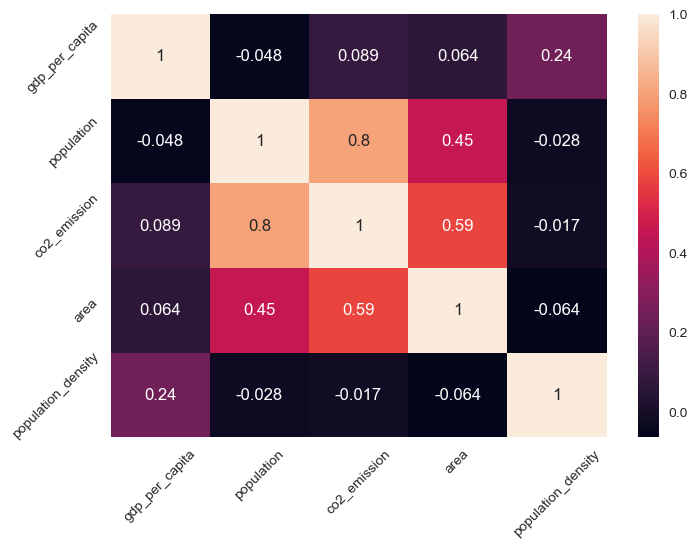

In [49]:
sns.heatmap(df.iloc[:, 2:].corr(), annot=True)
plt.xticks(rotation=45)
plt.yticks(rotation=45);